In [1]:
import scanpy as sc
from tidyverse.dummy import *
import pertpy as pt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams["figure.figsize"] = (4,3)

import sys
sys.path.append('..')
from util import load_original_data
from colormaps import color_dict_diagnosis, cmap_subtypes, cmap_subtypes
from matplotlib.colors import ListedColormap
from util import load_CODEX

Importing tidyverse


/tmp/ipykernel_216180/3338398648.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


In [2]:
plotfolder = '/tmp/codex/'
import os 
if not os.path.exists(plotfolder):
    os.mkdir(plotfolder)

# scRNAseq

In [3]:
adata = load_original_data()
codex_patients = ['E08', 'E11', 'E12', 'E17', 'E19', ]
adata = adata[adata.obs.patient.isin(codex_patients)]
adata.raw = adata

In [4]:
# cell types detected in both scRNAseq and CODEX
consensus_types = [
    'Columnar Epithelium',
    'Squamous Epithelium',    
    'Tcells',
    'Bcells',
    'Myeloid',
    'Fibroblasts',
    'Myofibroblasts',
    'Endothelial cells',    
]

diagnosis_ordered = ['NE', 'M','D','T', 'NS']
cluster_order = [
    'Columnar Epithelium', 
    'Squamous Epithelium',
    'Bcells', 
    'Tcells',
    'Myeloid',
    'Endothelial cells', 
    'Fibroblasts',
    'Myofibroblasts',
]

In [5]:
adata = adata[adata.obs.celltype_split.isin(consensus_types)]

In [6]:
cluster_name = 'celltype_split'

In [7]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(
    adata,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier=cluster_name,
    sample_identifier="samplename",
    covariate_obs=['samplename','diagnosis', 'procedure', 'patient'],
)
sccoda_data["coda"].obs['n_cells'] = sccoda_data["coda"].X.sum(1)
sccoda_data["coda"].obs['diagnosis'] = pd.Categorical(sccoda_data["coda"].obs['diagnosis'], diagnosis_ordered)

data_scanpy_1 = sccoda_data["coda"]

/opt/conda/lib/python3.11/site-packages/pertpy/tools/_coda/_base_coda.py:2601: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


/tmp/ipykernel_216180/2772454103.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


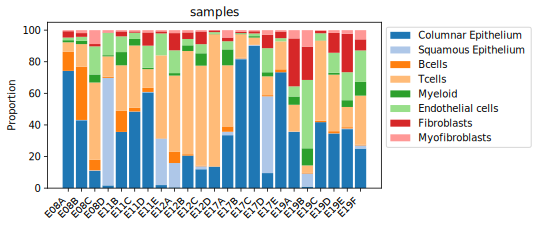

In [8]:
set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    sccoda_data['coda'][:, cluster_order],
    modality_key="coda",
    feature_name="samples",
    figsize=(6,3), show=False #, palette=cmap_reordered,
)

/tmp/ipykernel_216180/263624157.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


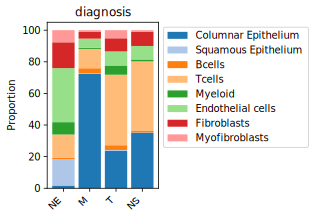

In [9]:
set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    sccoda_data['coda'][:, cluster_order],
    modality_key="coda",
    feature_name="diagnosis",
    figsize=(2,3), show=False #, palette=cmap_reordered,
)

# CODEX

In [10]:
mdata = load_CODEX()

/opt/conda/lib/python3.11/site-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are intersecting.


In [11]:
from sctools import adata_merge

just stack them all into a giant adata

In [12]:
adata_codex = adata_merge([
    mdata[samplename]  for samplename in sorted(mdata.mod_names)
], security_check=False)

sorting genes alphabetically
done sorting
ensuring compatibility
done ensuring compatibility


In [13]:
# get the naming consistent
codex_CTs = {
    'Tcells': ['CD4+ T cell',  'CD4+ T cell PD1+'] + ['CD4+ Treg'] + ['CD8+ T cell', 'CD8+ T cell PD1+'],
    'Bcells': ['B cell', 'Plasma'],
     'Myeloid': ['M1 Macrophage', 'M2 Macrophage'] + ['DC']+ ['Neutrophil'],
     'Squamous Epithelium': ['Squamou p63+ EGFRhi', 'Squamous Annexin A1+', 'Squamous p63+'],
     'Columnar Epithelium': [
    'Chief',
    'Foveloar',  'Foveloar Ki67+ p53+', 'Foveloar p53+',
    'Parietal',
    'Neck', 'Neck Ki67+ p53+', 'Neck p53+',
    'Neuroendocrine',
  ] + [
     'Goblet', 'Goblet Ki67+ p53+', 'Goblet p53+','Paneth'
     ]+ [
     'Epithelial', 'Epithelial CD73hi', 'Epithelial CK7+',
     'Epithelial CK7+ p53+', 'Epithelial HLADR+',
     'Epithelial Ki67+ p53+', 'Epithelial MUC1+ Ki67+',
     'Epithelial p53+', 'Epithelial pH2AX+',
    ],

  'Endothelial cells': ['Endothelial', 'Endothelial CD36hi', 'Endothelial aSMAhi'] + ['Lymphatic', 'Lymphatic CD73+'],
  'Fibroblasts': ['Stroma', 'Stroma CD73+'],
  'Myofibroblasts': ['Smooth Muscle'],
  'Other': ['Nerve']
}

def invert_dict(d):
    new_dict = {}
    for k, v_list in d.items():
        for v in v_list:
            assert v not in new_dict
            new_dict[v] = k
    return new_dict

codex_CTs_inv = invert_dict(codex_CTs)

adata_codex.obs['Cell Type 2'] = adata_codex.obs['Cell Type'].apply(lambda x: codex_CTs_inv[x])
adata_codex = adata_codex[adata_codex.obs['Cell Type 2'].isin(consensus_types)]
adata_codex.obs['Cell Type 2'] = pd.Categorical(adata_codex.obs['Cell Type 2'], consensus_types)

/tmp/ipykernel_216180/264767365.py:40: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


In [14]:
matt_diagnosis_dict = [
    #rediagnosisMatt    smaplename    #proc      # initial diag        # initial short
    ['T', 'E08_reg001', 'Biopsy',       'Tumor + Dysplasia', 'T'],
    ['NE','E08_reg002', 'Biopsy',       'Normal esophagus', 'NE'],
    ['NE','E08_reg003', 'Biopsy',       'Normal esophagus', 'NE'],
    ['T', 'E08_reg004', 'Biopsy',       'Tumor + Metaplasia', 'T'],
    ['T', 'E08_reg005', 'Biopsy',       'Tumor + Metaplasia', 'T'],
    ['M', 'E08_reg006', 'Biopsy',       'Metaplasia', 'M'],
    ['M', 'E08_reg007', 'Biopsy',       'Metaplasia', 'M'],
    ['T', 'E11_reg001', 'Biopsy',       'Tumor + Metaplasia', 'T'],
    ['T', 'E11_reg002', 'Biopsy',       'Tumor + Metaplasia', 'T'],
    ['T', 'E11_reg003', 'Biopsy',       'Metaplasia + Tumor', 'T'],
    ['D', 'E11_reg004', 'Biopsy',       'Metaplasia', 'M'],
    ['?', 'E11_reg005', 'Biopsy',       'Normal esophagus; Tumor?', 'NE/T'],
    ['?', 'E11_reg006', 'Biopsy',       'Normal esophagus; Tumor?', 'NE/T'],
    ['T', 'E18_reg001', 'Resection',    'Metaplasia', 'M'],
    ['T', 'E18_reg002', 'Resection',    'Metaplasia', 'M'],
    ['T', 'E18_reg003', 'Resection',    'Tumor', 'T'],
    ['T', 'E18_reg004', 'Resection',    'Tumor', 'T'],
    ['NE', 'E17_reg001', 'Biopsy',      'Normal esophagus', 'NE'],
    ['D', 'E17_reg002', 'Biopsy',       'Metaplasia; Dysplasia?', 'MD'],
    ['M', 'E17_reg003', 'Biopsy',       'Metaplasia; Dysplasia?', 'MD'],
    ['M', 'E17_reg004', 'Biopsy',       'Tumor', 'T'],
    ['T', 'E17_reg005', 'Biopsy',       'Metaplasia', 'M'],
    ['M', 'E17_reg006', 'Biopsy',       'Metaplasia', 'M'],
    ['NS', 'E19_reg001', 'Resection',   'Normal esophagus', 'NE'],
    ['T', 'E19_reg002', 'Resection',    'Normal esophagus', 'NE'],
    ['T', 'E19_reg003', 'Resection',    'Normal esophagus', 'NE'],
    ['T', 'E19_reg004', 'Resection',    'Normal esophagus', 'NE'],
    ['T','E12_reg001', 'Resection',     'Metaplasia + Dysplasia + Tumor', 'T'],
    ['M','E12_reg002', 'Resection',     'Metaplasia + Dysplasia + Tumor', 'T'],
    ['NS', 'E12_reg003', 'Resection',   'Metaplasia + Dysplasia + Tumor', 'T'],
    ['NE/NS',  'E12_reg004', 'Resection',       'Metaplasia + Dysplasia + Tumor', 'T'],
    ['NE/NS', 'E12_reg005', 'Resection',        'Metaplasia + Dysplasia + Tumor', 'T'],
]
matt_diagnosis_dict = pd.DataFrame(matt_diagnosis_dict, columns=['rediagnosis', 'samplename', 'procedure', 'matt_diagnosis', 'diagnosis'])
matt_diagnosis_dict['patient'] = matt_diagnosis_dict.samplename.apply(lambda x: x.split('_')[0])
matt_diagnosis_dict['rediagnosis'] = pd.Categorical(matt_diagnosis_dict['rediagnosis'] , ['NE', 'M','D','T','NS', 'NE/NS', '?'])

In [15]:
adata_codex.obs = adata_codex.obs.merge(matt_diagnosis_dict[['samplename', 'rediagnosis']], on='samplename')

In [16]:
sccoda_model = pt.tl.Sccoda()
cluster_name = 'Cell Type 2'
sccoda_data = sccoda_model.load(
    adata_codex,
    type="cell_level",
    generate_sample_level=True,
    cell_type_identifier=cluster_name,
    sample_identifier="samplename",
    covariate_obs=['samplename', 'rediagnosis', 'patient'],
)
sccoda_data["coda"].obs['n_cells'] = sccoda_data["coda"].X.sum(1)
data_codex = sccoda_data["coda"]

In [17]:
codex_order = data_codex.obs.sort_values(['rediagnosis', 'patient']).index.values
data_codex_ordered = data_codex[codex_order]

# filter out the unclear diagnoses
ddd = ['NE','M','D','T','NS']
data_codex_ordered = data_codex_ordered[data_codex_ordered.obs.rediagnosis.isin(ddd)]

/tmp/ipykernel_216180/3588171897.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


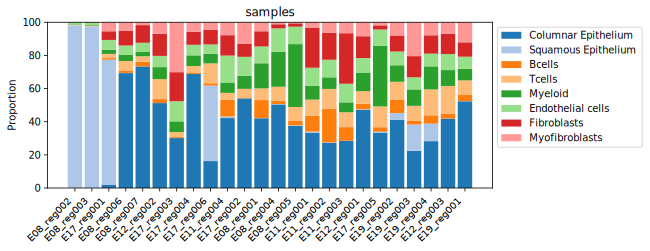

In [18]:
set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    data_codex_ordered[:, cluster_order],
    modality_key="coda",
    feature_name="samples",
    figsize=(8,3), show=False #, palette=cmap_reordered,
)

/tmp/ipykernel_216180/2636644046.py:1: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


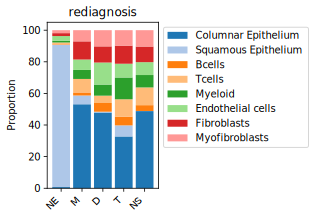

In [19]:
set_matplotlib_formats('svg')
fig = sccoda_model.plot_stacked_barplot(
    data_codex_ordered[:, cluster_order],
    modality_key="coda",
    feature_name="rediagnosis",
    figsize=(2,3), show=False #, palette=cmap_reordered,
)